# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = [1e-1, 1e-2, 1e-3]
LR = 1e-2
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.cuda.is_available())

True



### Dataset


In [5]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [6]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def initialize_model(device):
    model = ConvNet()
    model.to(device)
    return model

### Per batch training/testing

In [8]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss()
###############################################################

def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [9]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training（Learning Rate:1e-1）

In [10]:
model = initialize_model(device)

optimizer1 = optim.SGD(model.parameters(), lr=LEARNING_RATE[0], momentum=MOMENTUM)

scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=STEP, gamma=GAMMA)

In [11]:
training_loss1 = []
training_acc1 = []
testing_loss1 = []
testing_acc1 = []

start_time1 = time.time()


for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss1.append(epoch_loss)
    training_acc1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler1.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss1.append(val_loss)
        testing_acc1.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch + 1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))


end_time1 = time.time()

execution_time1 = end_time1 - start_time1

print(f"代码块执行时间为: {execution_time1} 秒")

Epoch: 1/30 Train Loss: 0.0153 Acc: 0.2688
Begin test......
Test Loss: 0.0139 Acc: 0.3544
Epoch: 2/30 Train Loss: 0.0143 Acc: 0.3220
Begin test......
Test Loss: 0.0138 Acc: 0.3555
Epoch: 3/30 Train Loss: 0.0140 Acc: 0.3305
Begin test......
Test Loss: 0.0135 Acc: 0.3542
Epoch: 4/30 Train Loss: 0.0139 Acc: 0.3425
Begin test......
Test Loss: 0.0137 Acc: 0.3565
Epoch: 5/30 Train Loss: 0.0138 Acc: 0.3450
Begin test......
Test Loss: 0.0132 Acc: 0.3797
Epoch: 6/30 Train Loss: 0.0130 Acc: 0.3840
Begin test......
Test Loss: 0.0125 Acc: 0.4092
Epoch: 7/30 Train Loss: 0.0129 Acc: 0.3867
Begin test......
Test Loss: 0.0124 Acc: 0.4164
Epoch: 8/30 Train Loss: 0.0127 Acc: 0.3993
Begin test......
Test Loss: 0.0125 Acc: 0.4069
Epoch: 9/30 Train Loss: 0.0127 Acc: 0.3971
Begin test......
Test Loss: 0.0126 Acc: 0.4105
Epoch: 10/30 Train Loss: 0.0126 Acc: 0.4023
Begin test......
Test Loss: 0.0126 Acc: 0.4171
Epoch: 11/30 Train Loss: 0.0123 Acc: 0.4209
Begin test......
Test Loss: 0.0115 Acc: 0.4651
Epoch: 1

### Model Training（Learning Rate:1e-2）

In [12]:
model = initialize_model(device)
optimizer2 = optim.SGD(model.parameters(), lr=LEARNING_RATE[1], momentum=MOMENTUM)

scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=STEP, gamma=GAMMA)

In [13]:
training_loss2 = []
training_acc2 = []
testing_loss2 = []
testing_acc2 = []

start_time2 = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer2.step()
        optimizer2.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss2.append(epoch_loss)
    training_acc2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler2.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss2.append(val_loss)
        testing_acc2.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

end_time2 = time.time()

execution_time2 = end_time2 - start_time2

print(f"代码块执行时间为: {execution_time2} 秒")

Epoch: 1/30 Train Loss: 0.0152 Acc: 0.2818
Begin test......
Test Loss: 0.0133 Acc: 0.3920
Epoch: 2/30 Train Loss: 0.0130 Acc: 0.3857
Begin test......
Test Loss: 0.0121 Acc: 0.4297
Epoch: 3/30 Train Loss: 0.0123 Acc: 0.4276
Begin test......
Test Loss: 0.0112 Acc: 0.4833
Epoch: 4/30 Train Loss: 0.0118 Acc: 0.4504
Begin test......
Test Loss: 0.0109 Acc: 0.5064
Epoch: 5/30 Train Loss: 0.0115 Acc: 0.4691
Begin test......
Test Loss: 0.0105 Acc: 0.5249
Epoch: 6/30 Train Loss: 0.0110 Acc: 0.4912
Begin test......
Test Loss: 0.0101 Acc: 0.5394
Epoch: 7/30 Train Loss: 0.0109 Acc: 0.4983
Begin test......
Test Loss: 0.0102 Acc: 0.5353
Epoch: 8/30 Train Loss: 0.0109 Acc: 0.5013
Begin test......
Test Loss: 0.0101 Acc: 0.5431
Epoch: 9/30 Train Loss: 0.0107 Acc: 0.5086
Begin test......
Test Loss: 0.0101 Acc: 0.5455
Epoch: 10/30 Train Loss: 0.0107 Acc: 0.5078
Begin test......
Test Loss: 0.0098 Acc: 0.5545
Epoch: 11/30 Train Loss: 0.0105 Acc: 0.5207
Begin test......
Test Loss: 0.0098 Acc: 0.5527
Epoch: 1

### Model Training（Learning Rate:1e-3）

In [14]:
model = initialize_model(device)
optimizer3 = optim.SGD(model.parameters(), lr=LEARNING_RATE[2], momentum=MOMENTUM)

scheduler3 = torch.optim.lr_scheduler.StepLR(optimizer3, step_size=STEP, gamma=GAMMA)

In [15]:
training_loss3 = []
training_acc3 = []
testing_loss3 = []
testing_acc3 = []

start_time3 = time.time()

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer3.step()
        optimizer3.zero_grad()

    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss3.append(epoch_loss)
    training_acc3.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler3.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss3.append(val_loss)
        testing_acc3.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
            
end_time3 = time.time()

execution_time3 = end_time3 - start_time3

print(f"代码块执行时间为: {execution_time3} 秒")

Epoch: 1/30 Train Loss: 0.0179 Acc: 0.1305
Begin test......
Test Loss: 0.0178 Acc: 0.1315
Epoch: 2/30 Train Loss: 0.0167 Acc: 0.1980
Begin test......
Test Loss: 0.0159 Acc: 0.2618
Epoch: 3/30 Train Loss: 0.0157 Acc: 0.2603
Begin test......
Test Loss: 0.0153 Acc: 0.2912
Epoch: 4/30 Train Loss: 0.0152 Acc: 0.2895
Begin test......
Test Loss: 0.0147 Acc: 0.3217
Epoch: 5/30 Train Loss: 0.0146 Acc: 0.3160
Begin test......
Test Loss: 0.0140 Acc: 0.3613
Epoch: 6/30 Train Loss: 0.0141 Acc: 0.3398
Begin test......
Test Loss: 0.0136 Acc: 0.3789
Epoch: 7/30 Train Loss: 0.0138 Acc: 0.3573
Begin test......
Test Loss: 0.0132 Acc: 0.3963
Epoch: 8/30 Train Loss: 0.0136 Acc: 0.3693
Begin test......
Test Loss: 0.0129 Acc: 0.4087
Epoch: 9/30 Train Loss: 0.0134 Acc: 0.3774
Begin test......
Test Loss: 0.0127 Acc: 0.4186
Epoch: 10/30 Train Loss: 0.0132 Acc: 0.3878
Begin test......
Test Loss: 0.0125 Acc: 0.4282
Epoch: 11/30 Train Loss: 0.0130 Acc: 0.3929
Begin test......
Test Loss: 0.0124 Acc: 0.4302
Epoch: 1

### Visualization

In [16]:
import matplotlib.pyplot as plt
x = np.arange(NUM_EPOCHS)

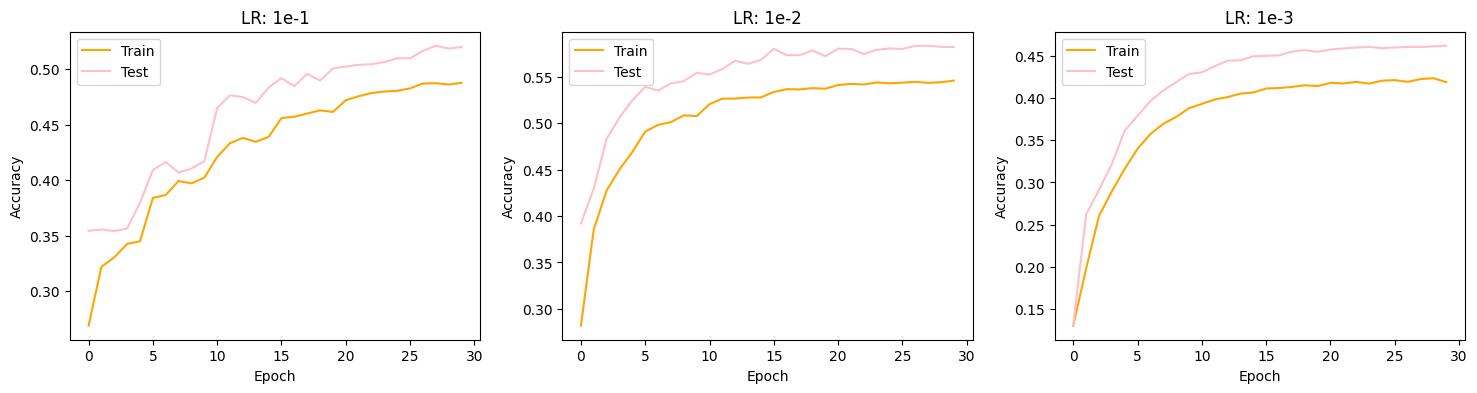

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# 绘制 LR=1e-1 的曲线
axs[0].set_title("LR: 1e-1")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].plot(x, training_acc1, label="Train", color="orange", linestyle="-")
axs[0].plot(x, testing_acc1, label="Test", color="pink", linestyle="-")
axs[0].legend()

# 绘制 LR=1e-2 的曲线
axs[1].set_title("LR: 1e-2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].plot(x, training_acc2, label="Train", color="orange", linestyle="-")
axs[1].plot(x, testing_acc2, label="Test", color="pink", linestyle="-")
axs[1].legend()

# 绘制 LR=1e-3 的曲线
axs[2].set_title("LR: 1e-3")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Accuracy")
axs[2].plot(x, training_acc3, label="Train", color="orange", linestyle="-")
axs[2].plot(x, testing_acc3, label="Test", color="pink", linestyle="-")
axs[2].legend()

plt.show()


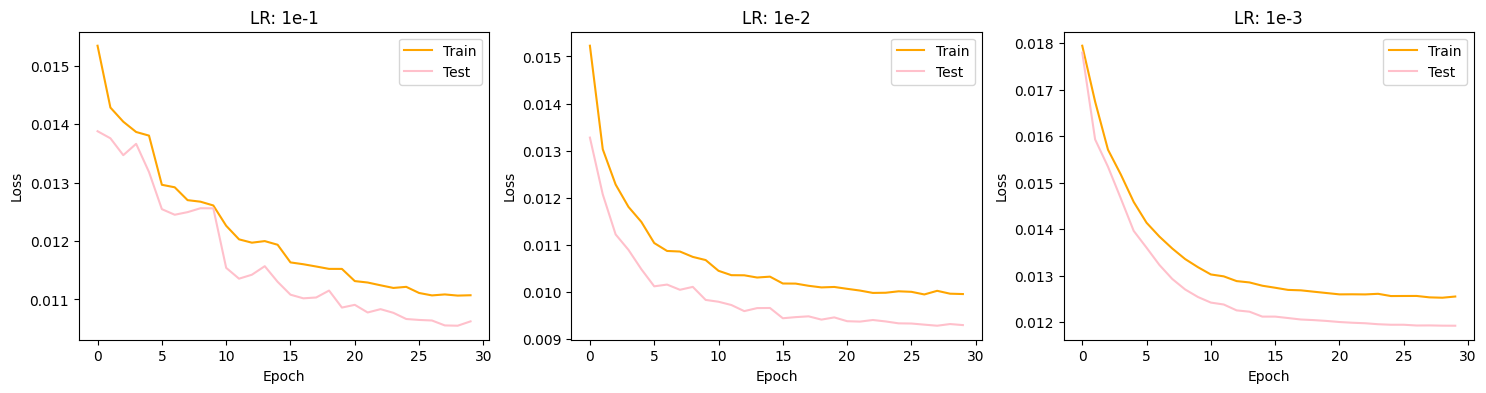

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

# 绘制 LR=1e-1 的损失曲线
axs[0].set_title("LR: 1e-1")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].plot(x, training_loss1, label="Train", color="orange", linestyle="-")
axs[0].plot(x, testing_loss1, label="Test", color="pink", linestyle="-")
axs[0].legend()

# 绘制 LR=1e-2 的损失曲线
axs[1].set_title("LR: 1e-2")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].plot(x, training_loss2, label="Train", color="orange", linestyle="-")
axs[1].plot(x, testing_loss2, label="Test", color="pink", linestyle="-")
axs[1].legend()

# 绘制 LR=1e-3 的损失曲线
axs[2].set_title("LR: 1e-3")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss")
axs[2].plot(x, training_loss3, label="Train", color="orange", linestyle="-")
axs[2].plot(x, testing_loss3, label="Test", color="pink", linestyle="-")
axs[2].legend()

plt.show()


### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [19]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]
input = input.to('cuda')

In [20]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################

output = model(input)
probabilities = torch.softmax(output, dim = 1)
predict_label = torch.argmax(probabilities, dim = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


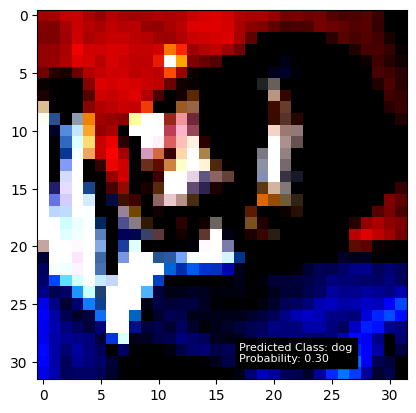

Print probabilities for each class:
airplane: 0.0368
automobile: 0.0302
bird: 0.0961
cat: 0.2852
deer: 0.0542
dog: 0.2962
frog: 0.0617
horse: 0.0401
ship: 0.0678
truck: 0.0318


In [21]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0][predict_label].item()

image = input.cpu().numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0][i].item():.4f}')